In [1]:
%%bash
echo "🧹 Removing broken Triton & bitsandbytes folders..."

rm -rf /usr/local/lib/python3.*/dist-packages/triton*
rm -rf /usr/local/lib/python3.*/dist-packages/bitsandbytes*
rm -rf /usr/local/lib/python3.*/dist-packages/bnb*


🧹 Removing broken Triton & bitsandbytes folders...


In [2]:
%%bash
echo "⬇️ Installing PyTorch + bitsandbytes + triton combo known to work"

pip install -q --no-cache-dir torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 \
  -f https://download.pytorch.org/whl/torch_stable.html

pip install -q --no-cache-dir triton==2.1.0.post1
pip install -q --no-cache-dir bitsandbytes==0.43.1

pip install -q --no-cache-dir \
  transformers==4.41.1 peft==0.11.1 accelerate==0.29.3 datasets einops requests


⬇️ Installing PyTorch + bitsandbytes + triton combo known to work
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 129.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 240.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 245.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 236.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 255.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 200.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 356.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 242.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 246.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 153.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1

ERROR: Could not find a version that satisfies the requirement triton==2.1.0.post1 (from versions: 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 3.0.0, 3.1.0, 3.2.0, 3.3.0, 3.3.1)
ERROR: No matching distribution found for triton==2.1.0.post1


In [4]:
import os, gc, time, torch, psutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

MODEL_ID = "tiiuae/falcon-rw-1b"
MAX_LEN = 128
BATCH_SIZE = 8
STEPS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [5]:
import pandas as pd
from datasets import Dataset
csv_url = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
columns = ["label", "title", "description"]
df = pd.read_csv(csv_url, names=columns)
df = df.sample(frac=1, random_state=42).reset_index(drop=True).head(3200)
df["text"] = df["title"] + ". " + df["description"]
df = df[["text", "label"]].astype({"label": int})

raw_ds = Dataset.from_pandas(df.iloc[:2400])
val_ds = Dataset.from_pandas(df.iloc[2400:])

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_tok = AutoTokenizer.from_pretrained(MODEL_ID)
model_tok.pad_token = model_tok.eos_token

prompt = lambda t: f"Classify this: {t}\nLabel:"

def tokenize(example):
    ids = model_tok(prompt(example["text"]), truncation=True, max_length=MAX_LEN).input_ids
    return {"input_ids": ids, "labels": ids.copy()}

train_ds = raw_ds.map(tokenize)
val_ds   = val_ds.map(tokenize)

pad_id = model_tok.pad_token_id

def collate_fn(batch):
    ids  = [torch.tensor(b["input_ids"]) for b in batch]
    lbls = [torch.tensor(b["labels"]) for b in batch]
    min_len = min(map(len, ids))
    ids  = [x[:min_len] for x in ids]
    lbls = [x[:min_len] for x in lbls]
    return {
        "input_ids": pad_sequence(ids, True, pad_id).to(DEVICE),
        "labels": pad_sequence(lbls, True, -100).to(DEVICE)
    }

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [7]:
mem_record = {}

# Save directory for plots
os.makedirs("plots", exist_ok=True)

def train_with_plot(model, label):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=5e-6)
    losses = []
    mem_gb = []

    for step, batch in enumerate(train_loader, 1):
        opt.zero_grad(set_to_none=True)
        loss = model(**batch).loss
        if torch.isnan(loss): continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        losses.append(loss.item())
        mem_gb.append(torch.cuda.max_memory_allocated() / 1e9)

        if step % 5 == 0 or step == STEPS:
            clear_output(wait=True)
            plt.figure(figsize=(12, 4))

            plt.subplot(1,2,1)
            plt.plot(losses, label=label)
            plt.xlabel("Steps"); plt.ylabel("Loss"); plt.title(f"{label} Loss")
            plt.grid(); plt.legend()

            plt.subplot(1,2,2)
            plt.plot(mem_gb, label="GPU GB", color="r")
            plt.xlabel("Steps"); plt.ylabel("Memory (GB)")
            plt.title(f"{label} GPU Usage")
            plt.grid(); plt.legend()

            plt.tight_layout()
            plt.savefig(f"plots/{label}_plot.png")
            plt.show()

        if step >= STEPS: break

    mem_record[label] = max(mem_gb)
    return losses

In [8]:
@torch.no_grad()
def accuracy(model):
    model.eval(); tot = 0; ok = 0
    for batch in val_loader:
        pred = model.generate(batch["input_ids"], max_new_tokens=1)[:, -1]
        gold = batch["labels"][:, -1]
        tot += len(gold)
        ok += (pred == gold).sum().item()
    return ok / tot

# ⚙️ Configs
lora_cfg = LoraConfig(r=4, lora_alpha=16, lora_dropout=0.05, bias="none", target_modules=["query_key_value","dense"])
qlora_cfg = LoraConfig(r=8, lora_alpha=32, lora_dropout=0.05, bias="none", target_modules=["query_key_value","dense"])
draft_cfg = LoraConfig(r=4, lora_alpha=32, lora_dropout=0.05, bias="none", target_modules=["query_key_value","dense"])

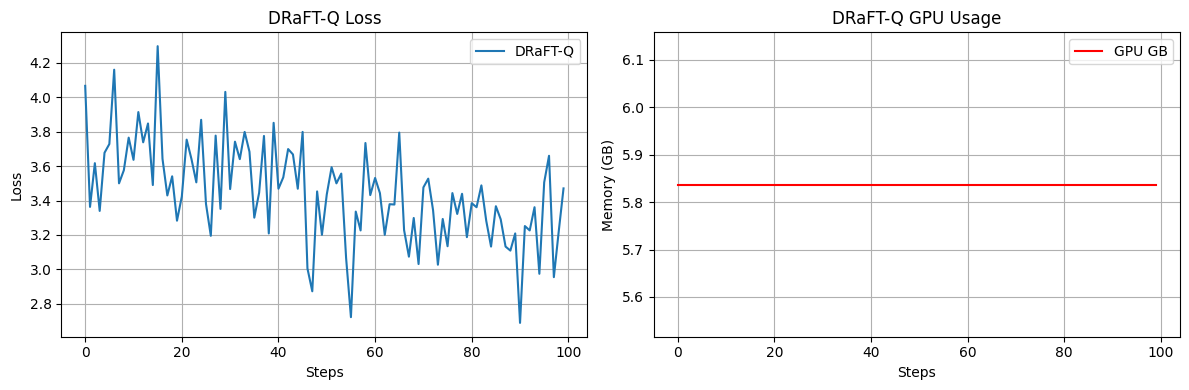

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

DRaFT-Q Accuracy: 0.000 | Max GPU: 5.84 GB


In [16]:
for label, cfg in zip(["LoRA", "QLoRA", "DRaFT-Q"], [lora_cfg, qlora_cfg, draft_cfg]):
    print(f"\n🔧 Training {label}...")
    if "qlora" in label.lower():
        base = model_fn(quant_cfg=bnb_4bit)
        base = prepare_model_for_kbit_training(base)
    else:
        base = model_fn(quant_cfg=bnb_8bit)
    model = get_peft_model(base, cfg)
    model.to(DEVICE)
    train_with_plot(model, label)
    acc = accuracy(model)
    print(f"{label} Accuracy: {acc:.3f} | Max GPU: {mem_record[label]:.2f} GB")
    del model; gc.collect(); torch.cuda.empty_cache()

In [17]:
for k, v in mem_record.items():
    print(f"{k:10s} GPU Peak: {v:.2f} GB")

LoRA       GPU Peak: 5.84 GB
QLoRA      GPU Peak: 5.84 GB
DRaFT-Q    GPU Peak: 5.84 GB
